## Part 3: Machine Learning with Clustering

In [30]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import rcParams
import seaborn as sns

%matplotlib inline

sns.set_style("darkgrid")
#sns.set(rc={"figure.dpi":600, 'savefig.dpi':600})
params = {'axes.titlesize': 18.0, 
          'axes.labelsize': 16.0, 
          'legend.fontsize': 16.0,
          'xtick.labelsize': 12.0,        
          'ytick.labelsize': 12.0}
plt.rcParams.update(params)

from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans
from sklearn import metrics

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings("ignore")

In [2]:
customer = pd.read_csv('EDACustomer.csv').drop('Unnamed: 0', axis = 1)
offer = pd.read_csv('EDAOffer.csv').drop('Unnamed: 0', axis = 1)
transcript = pd.read_csv('EDATranscript.csv').drop('Unnamed: 0', axis = 1)

### Customer Characteristics
Before clustering, the customer and transcript datasets need to be combined so that the customer behaviors can be grouped.

In [3]:
# Creating an empty dataframe
customer_behaviors = pd.DataFrame(columns = ['person', 'received', 
                                            'viewed', 'completed', 'transactions'])

In [4]:
# The customers with NaN for income and gender were dropped from the customer 
# dataset in part 1, so the list of the ids currently in the customer dataset
# can be used to keep only the non null ids in transcript 
not_null_ids = customer['id']
filtered_transcript = transcript[transcript['person'].isin(not_null_ids)].reset_index(drop = True)

# And then added to customer_behaviors
customer_behaviors['person'] = filtered_transcript.value_counts('person').sort_index().index.values
customer_behaviors.set_index('person', inplace = True)

In [5]:
# Getting counts of each offer event by each customer 
filtered_transcript = filtered_transcript.sort_values('person')
grouped_transcript = filtered_transcript.groupby(['person', 'event']).count()

In [6]:
# Now filling in received, viewed, completed, and transactions 
for person_id in customer_behaviors.index.values:
    if (person_id, 'offer received') in list(grouped_transcript.index.values):
        customer_behaviors.loc[person_id, 'received'] = grouped_transcript.loc[(person_id, 'offer received'), 'key_id']
    if (person_id, 'offer viewed') in list(grouped_transcript.index.values):
        customer_behaviors.loc[person_id, 'viewed'] = grouped_transcript.loc[(person_id, 'offer viewed'), 'key_id']
    if (person_id, 'offer completed') in list(grouped_transcript.index.values):
        customer_behaviors.loc[person_id, 'completed'] = grouped_transcript.loc[(person_id, 'offer completed'), 'key_id']
    if (person_id, 'transaction') in list(grouped_transcript.index.values):
        customer_behaviors.loc[person_id, 'transactions'] = grouped_transcript.loc[(person_id, 'transaction'), 'key_id']
    

In [10]:
# Saving this since the above code chunk to over 4 minutes :) 
#customer_behaviors.to_csv('customer_behaviors.csv')

Now that we have a dataset with customer behaviors, we can find out how much each customer spent with value_id

In [12]:
x = filtered_transcript[filtered_transcript['event'] == 'transaction']
x['value_id'] = x['value_id'].astype(float)

# Calculating how much money each customer spent 
money_spent = x[x['event'] == 'transaction'].groupby('person').agg({'value_id': 'sum'})

# And adding money_spent to customer_behaviors
customer_behaviors['money_spent'] = money_spent

### Analysis of customer_behavior

In [13]:
customer_behaviors.isna().sum()

received           5
viewed           150
completed       2839
transactions     333
money_spent      333
dtype: int64

From above, we can see that: 
- 5 customers did not receive an offer
- 150 customers did not view the offer
- 2839 customers did not complete the offer
- 333 customers did not make any purchases nor did they spend any money

We'll replace NaNs with 0s in the customer_behavior dataset.

In [14]:
# Filling NaN
customer_behaviors.fillna(0, inplace = True)

# And keeping a copy
#customer_behavior_received = customer_behavior.copy()


#### Outliers

In [15]:
customer_behaviors['money_spent'].describe()

count    14825.000000
mean       117.028155
std        129.965016
min          0.000000
25%         31.450000
50%         87.040000
75%        160.900000
max       1608.690000
Name: money_spent, dtype: float64

The 0.75 quantile is only $160, while the maximum is $1608. The top 2.5 % can be removed. 

In [16]:
# Removing rows with customers who's spending falls into the top 2.5%
q = customer_behaviors['money_spent'].quantile(0.975)

top_spenders_outliers = customer_behaviors[customer_behaviors['money_spent'] >= q]

customers_to_keep = customer_behaviors[customer_behaviors['money_spent'] < q]

print('Number of rows removed:', top_spenders_outliers.shape[0])

Number of rows removed: 371


In [22]:
# Keeping unaltered copy 
filtered_customers = customers_to_keep.copy()

Before scaling the data for clustering, the received column needs to be dropped from the customer_behavior data. This is because the customer did not decided whether or not to receive the offer. Starbucks decided who to send the offers too. 

In [23]:
clean_customers = filtered_customers.drop('received', axis = 1)
clean_customers.head(5)

,viewed,completed,transactions,money_spent
person,,,,
0009655768c64bdeb2e877511632db8f,4,3,8,127.60
0011e0d4e6b944f998e987f904e8c1e5,5,3,5,79.46
0020c2b971eb4e9188eac86d93036a77,3,3,8,196.86
0020ccbbb6d84e358d3414a3ff76cffd,4,3,12,154.05
003d66b6608740288d6cc97a6903f4f0,4,3,18,48.34


#### Scaling

In [24]:
sc = StandardScaler().fit(clean_customers)
scaled = sc.transform(clean_customers)
scaled_features = pd.DataFrame(data = scaled, 
                               columns = clean_customers.columns.values)

****
## Clustering 
Yay! Finally to the machine learning. First, we're going to find the ideal number of clusters. 

In [27]:
df_feature = scaled_features
wcss = []
sil_score = []
max_clusters = 10

for k in range(1, max_clusters):
    kmeans = KMeans(n_clusters = k, random_state = 10)
    kmeans.fit(df_feature)
    
    # calculate wcss for the Elbow Method
    wcss.append(kmeans.inertia_)
    
    # calculate the mean Silhouette coefficient
    if k >= 2:
        labels = kmeans.labels_
        sil_score.append(metrics.silhouette_score(df_feature, labels))
# converting the results into a dataframe and plotting them

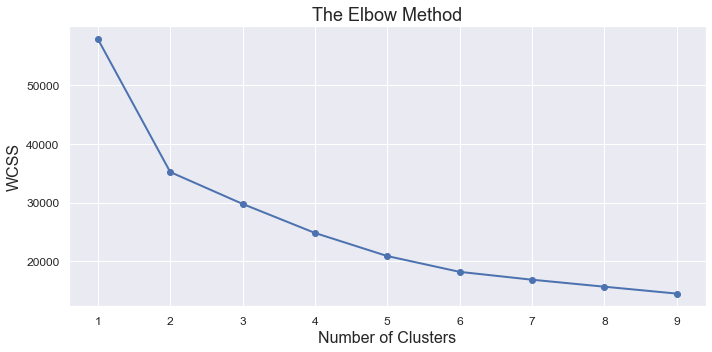

In [38]:
fig, ax = plt.subplots(figsize=(10,5))
# Elbow 
ax.plot(np.arange(1, max_clusters), wcss, marker = 'o', lw = 2)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('WCSS')
ax.set_title('The Elbow Method')
plt.tight_layout()
plt.show()


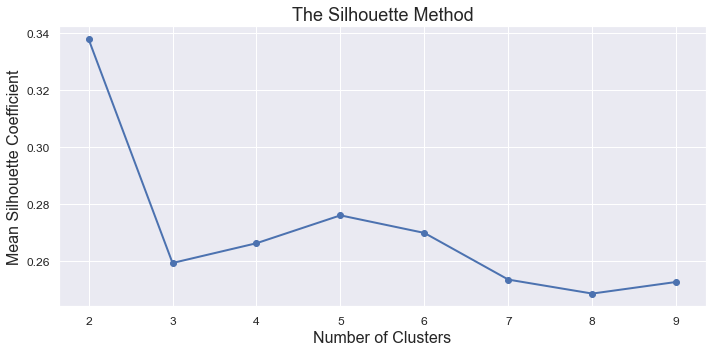

In [36]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(np.arange(2, max_clusters), sil_score, marker = 'o' , lw = 2)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Mean Silhouette Coefficient')
ax.set_title('The Silhouette Method')
plt.tight_layout()
plt.show()

5 appears to be the ideal number of clusters (k)

**Now KMeans clustering can be done!**

In [40]:
k = 5
df_feature = scaled

kmeans = KMeans(n_clusters = k, random_state = 10)
kmeans.fit_transform(df_feature)
customer_with_clusters = clean_customers.assign(cluster = kmeans.labels_)
print(customer_with_clusters.value_counts('cluster').sort_index())


cluster
0    1574
1    3337
2    4000
3    2921
4    2622
dtype: int64


Above we can see how many customers belong to each cluster.

In [41]:

print('Silhouette Score:', metrics.silhouette_score(df_feature, labels = kmeans.labels_))
cluster_info = customer_with_clusters.groupby('cluster').agg([np.mean])
print(cluster_info.round(1))

Silhouette Score: 0.27614911424041494
        viewed completed transactions money_spent
          mean      mean         mean        mean
cluster                                          
0          3.5       2.0         17.1        71.1
1          2.8       2.9          7.7       139.0
2          2.1       0.7          5.0        34.3
3          4.4       4.1         12.1       216.6
4          4.5       1.4          4.5        49.6


And here we have the mean of each customer behavior by cluster grouping